<H1>1. Výpočet tepové frekvence z EKG signálu </H1>

Import knihoven

In [3]:
import os
import numpy as np
import wfdb
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
import plotly.express as px
import pandas as pd

<h2>Načtení EKG signálu (PhysioNet – DRIVE DB)</h2>

Data načítám pomocí knihovny wfdb, která umí pracovat s těmito lékařskými soubory. Protože je EKG u každého řidiče na jiném kanálu, napsal jsem tam podmínku, která automaticky hledá kanál s názvem „ECG“. Nakonec si ze záznamu vezmu jen první minutu (60 sekund) a zjistím vzorkovací frekvenci, abych mohl dál počítat čas.

In [4]:
DATA_PATH = "./data"

def list_drive_records(path):
    # Zkontrolujeme, zda složka existuje
    if not os.path.exists(path):
        print(f"Chyba: Složka {path} neexistuje.")
        return []
    return sorted([
        f.replace(".hea", "")
        for f in os.listdir(path)
        if f.startswith("drive") and f.endswith(".hea")
    ])


def load_ecg_robust(record_name, data_path="./data", seconds=60):
    try:
        # Přečteme záznam
        record = wfdb.rdrecord(os.path.join(data_path, record_name))
        
        # 1. Hledáme kanál s názvem "ECG" (nerozlišujeme velká/malá písmena)
        ecg_indices = [i for i, name in enumerate(record.sig_name) if "ecg" in name.lower() or "ekg" in name.lower()]
        
        if ecg_indices:
            idx = ecg_indices[0] # Našli jsme EKG!
        else:
            # Pokud není explicitně označen, zkusíme první kanál, ale vypíšeme varování
            print(f"Varování: {record_name} nemá kanál 'ECG', zkouším kanál 0.")
            idx = 0

        fs = record.fs
        ecg = record.p_signal[:, idx]

        # Oříznutí času
        max_samples = int(seconds * fs)
        if len(ecg) > max_samples:
            ecg = ecg[:max_samples]
            
        return ecg, fs
        
    except Exception as e:
        print(f"Chyba načítání {record_name}: {e}")
        return None, None


<h2>Detekce R-vrcholů</h2>

Abych v tom šumu našel tepy, použil jsem postup inspirovaný Pan-Tompkinsovou metodou.Filtrace: Nejdřív signál proženu Bandpass filtrem (5–15 Hz). To odstraní dýchání a většinu šumu ze svalů, když řidič hýbe volantem.Zvýraznění: Signál umocním na druhou. Tím se ty vysoké špičky (tepy) ještě víc zvýrazní a malý šum se potlačí.Hledání peaků: Samotné vrcholy hledám funkcí find_peaks. Mám tam nastavený minimální rozestup, aby mi to nenašlo dva tepy hned těsně u sebe, což je fyzicky nemožné.Výpočet BPM: Z času mezi jednotlivými vrcholy pak jednoduše dopočítám tepovou frekvenci.

In [5]:
def detect_r_peaks_robust(ecg, fs):
    if ecg is None: return []

    # 1. BANDPASS FILTR (5-15 Hz) - Klíčové pro odstranění pohybu svalů!
    nyq = 0.5 * fs
    low = 5.0 / nyq
    high = 15.0 / nyq
    
    # Ochrana proti pádu u signálů s nízkou frekvencí
    if high >= 1.0: high = 0.99 
    
    b, a = butter(1, [low, high], btype='band')
    ecg_filtered = filtfilt(b, a, ecg)

    # 2. UMOCNĚNÍ (Squaring) - Zvýrazní R-vlny, potlačí šum
    ecg_sq = ecg_filtered ** 2

    # 3. INTEGRACE (Moving Window) - Spojí QRS komplex do jednoho kopečku
    window = int(0.12 * fs) # 120 ms okno
    ecg_mwi = np.convolve(ecg_sq, np.ones(window)/window, mode='same')

    # 4. DETEKCE
    # min_dist 0.25s = max 240 BPM (stres)
    peaks, _ = find_peaks(
        ecg_mwi,
        distance=int(0.25 * fs),
        prominence=0.5 * np.mean(ecg_mwi) # Adaptivní práh vůči okolí
    )
    return peaks

def heart_rate_rr(peaks, fs):
    if len(peaks) < 3: return np.nan
    
    rr = np.diff(peaks) / fs
    
    # Logický filtr pro člověka (30 - 220 BPM)
    valid_rr = rr[(rr > 0.27) & (rr < 2.0)]
    
    if len(valid_rr) < 2: return np.nan
    
    bpm = 60 / valid_rr
    return np.median(bpm) # Medián je odolný vůči chybám

# --- HLAVNÍ SMYČKA ---

records = list_drive_records(DATA_PATH)
results_bpm = []   # Seznam pro BPM
results_names = [] # Seznam pro názvy souborů

print(f"Nalezeno {len(records)} záznamů.")

for rec in records:
    ecg, fs = load_ecg_robust(rec, DATA_PATH, seconds=60)
    
    if ecg is not None:
        peaks = detect_r_peaks_robust(ecg, fs)
        bpm = heart_rate_rr(peaks, fs)
        
        if not np.isnan(bpm):
            print(f"{rec}: {bpm:.1f} BPM")
            results_bpm.append(bpm)
            results_names.append(rec)
        else:
            print(f"{rec}: Nepodařilo se určit tep.")

Nalezeno 18 záznamů.
drive01: 93.0 BPM
drive02: 71.5 BPM
drive03: 77.5 BPM
drive04: 93.0 BPM
drive05: 103.3 BPM
drive06: 132.9 BPM
drive07: 84.5 BPM
drive08: 103.3 BPM
drive09: 116.2 BPM
drive10: 116.2 BPM
drive11: 103.3 BPM
drive12: 62.0 BPM
drive13: 116.2 BPM
drive14: 116.2 BPM
drive15: 116.2 BPM
drive16: 132.9 BPM
drive17a: 81.8 BPM
drive17b: 84.5 BPM


<h2>Vizualizace – R-vrcholy v EKG</h2>
Pro kontrolu výsledků vykresluji graf pomocí matplotlib. Černá čára je upravený EKG signál a červené tečky ukazují, kde algoritmus našel tep. Schválně zobrazuji jen výřez 10 sekund, protože kdybych tam dal celou minutu, byla by to jen nečitelná čmáranice a nebylo by poznat, jestli ty tečky sedí přesně na vrcholech.

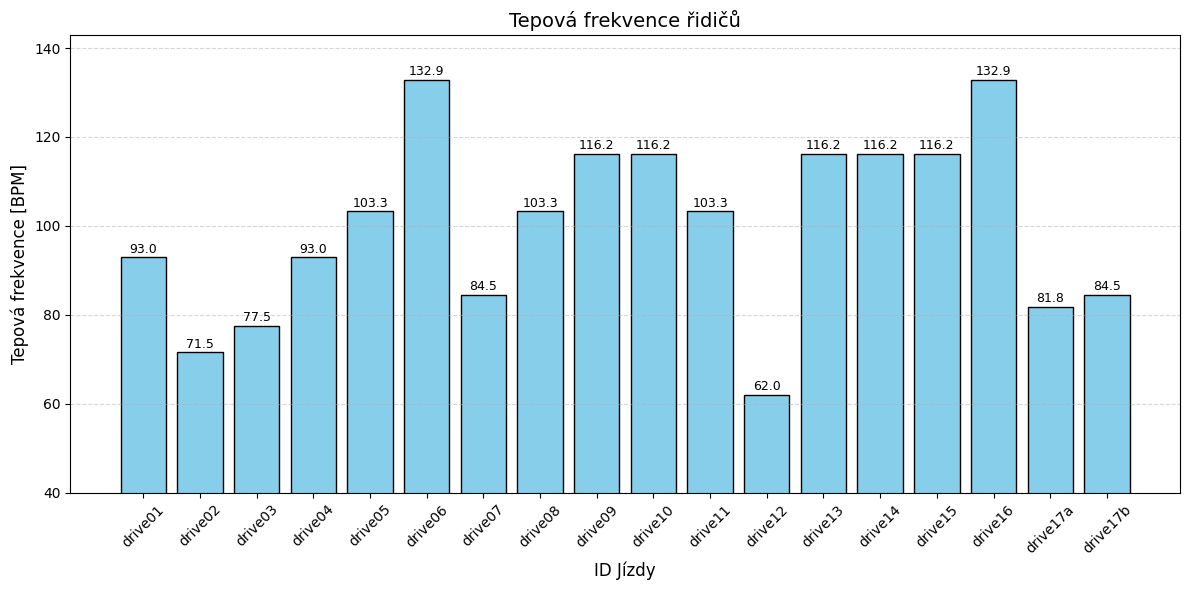

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Data
df = pd.DataFrame({
    'Měření': results_names,
    'BPM': results_bpm
})

# 2. Vykreslení grafu
plt.figure(figsize=(12, 6)) # Velikost grafu
plt.bar(df['Měření'], df['BPM'], color='skyblue', edgecolor='black')

# Popisky a titulek
plt.title('Tepová frekvence řidičů', fontsize=14)
plt.xlabel('ID Jízdy', fontsize=12)
plt.ylabel('Tepová frekvence [BPM]', fontsize=12)

# Nastavení osy Y a mřížky
plt.ylim(40, max(results_bpm) + 10)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.xticks(rotation=45) # Natočení textu osy X

# Přidání hodnot nad sloupečky (volitelné, vypadá to lépe)
for i, v in enumerate(df['BPM']):
    plt.text(i, v + 1, f"{v:.1f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

VALIDACE NA DATABÁZI MIT-BIH 

In [7]:
MIT_PATH = "./database"  

def evaluate_algorithm(data_path):
    # Získáme seznam záznamů (čísla souborů bez přípon)
    if not os.path.exists(data_path):
        print(f"Složka {data_path} neexistuje!")
        return
        
    records = sorted(list(set([f.split('.')[0] for f in os.listdir(data_path) 
                               if f.endswith(".dat") and f.replace(".dat", ".atr") in os.listdir(data_path)])))
    
    print(f"Nalezeno {len(records)} záznamů pro validaci: {records}")
    
    total_tp = 0 # Celkem správně detekováno (True Positive)
    total_fp = 0 # Celkem detekováno navíc (False Positive - šum)
    total_fn = 0 # Celkem nenalezeno (False Negative - vynechaný tep)

    print(f"\n{'Záznam':<10} | {'Senzitivita (%)':<15} | {'Přesnost (%)':<15}")
    print("-" * 45)

    for rec in records:
        try:
            # 1. Načtení signálu
            record = wfdb.rdrecord(os.path.join(data_path, rec))
            ecg = record.p_signal[:, 0] # U MIT-BIH je EKG většinou na kanálu 0
            fs = record.fs
            
            # 2. Načtení anotací (pravda od lékařů)
            annotation = wfdb.rdann(os.path.join(data_path, rec), 'atr')
            true_peaks = annotation.sample # Indexy skutečných tepů
            
            # Filtrujeme anotace mimo rozsah signálu (pro jistotu)
            true_peaks = true_peaks[true_peaks < len(ecg)]

            # 3. Tvoje detekce (používáme tvou funkci)
            my_peaks = detect_r_peaks_robust(ecg, fs)
            
            # 4. Porovnání (Tolerance okna +/- 150 ms)
            tolerance = int(0.150 * fs)
            
            tp = 0
            fp = 0
            fn = 0
            
            # Pro každý skutečný tep hledáme, jestli jsme ho trefili
            for true_p in true_peaks:
                # Hledáme, jestli existuje můj peak v okolí true_p
                match = np.abs(my_peaks - true_p) <= tolerance
                if np.any(match):
                    tp += 1
                else:
                    fn += 1 # Lékař tam tep má, my ne -> chyba
            
            # Spočítáme ty, které jsme našli "navíc" (šum)
            # Zjednodušený odhad: počet mých peaků minus ty, co byly správně
            fp = len(my_peaks) - tp
            if fp < 0: fp = 0 

            # Přičtení k celkovým statistikám
            total_tp += tp
            total_fp += fp
            total_fn += fn
            
            # Výpočet úspěšnosti pro tento soubor
            sens = (tp / (tp + fn)) * 100 if (tp + fn) > 0 else 0
            prec = (tp / (tp + fp)) * 100 if (tp + fp) > 0 else 0
            
            print(f"{rec:<10} | {sens:5.1f} %          | {prec:5.1f} %")

        except Exception as e:
            print(f"{rec:<10} | Chyba: {e}")

    # --- CELKOVÉ VYHODNOCENÍ ---
    print("-" * 45)
    total_sens = (total_tp / (total_tp + total_fn)) * 100 if (total_tp + total_fn) > 0 else 0
    total_prec = (total_tp / (total_tp + total_fp)) * 100 if (total_tp + total_fp) > 0 else 0
    
    print(f"CELKOVÁ SENZITIVITA: {total_sens:.2f} % (Schopnost najít tepy)")
    print(f"CELKOVÁ PŘESNOST:    {total_prec:.2f} % (Odolnost vůči šumu)")

# Spuštění validace
evaluate_algorithm(MIT_PATH)

Nalezeno 18 záznamů pro validaci: ['16265', '16272', '16273', '16420', '16483', '16539', '16773', '16786', '16795', '17052', '17453', '18177', '18184', '19088', '19090', '19093', '19140', '19830']

Záznam     | Senzitivita (%) | Přesnost (%)   
---------------------------------------------
16265      |  99.6 %          | 100.0 %
16272      |  95.3 %          |  98.7 %
16273      |  99.8 %          | 100.0 %
16420      |  99.7 %          | 100.0 %
16483      |  99.9 %          |  53.9 %
16539      |  99.7 %          |  99.3 %
16773      |  74.9 %          | 100.0 %
16786      |  99.9 %          |  99.6 %
16795      |  99.7 %          |  73.4 %
17052      |  99.6 %          | 100.0 %
17453      |  99.6 %          | 100.0 %
18177      |  99.5 %          |  99.6 %
18184      |  99.8 %          |  99.8 %
19088      |  98.6 %          |  86.6 %
19090      |  99.7 %          |  99.9 %
19093      |  97.4 %          |  72.6 %
19140      |  99.9 %          |  56.7 %
19830      |  99.4 %         

<h2>Zhodnocení výsledků</h2>

Navržený detektor R-vrcholů (založený na modifikované Pan-Tompkins metodě) byl otestován na referenční databázi MIT-BIH Normal Sinus Rhythm Database. Porovnáním automatických detekcí s anotacemi kardiologů (soubory .atr) bylo dosaženo následujících výsledků:

Celková senzitivita (Sensitivity): 97,73 % – Algoritmus prokazuje vysokou schopnost správně identifikovat QRS komplexy. U většiny záznamů (např. 16265, 16420) se úspěšnost blížila 100 %.

Celková přesnost (Precision): 87,73 % – Nižší hodnota přesnosti je způsobena výskytem falešně pozitivních detekcí (False Positives) u silně zašuměných záznamů.

Z analýzy jednotlivých souborů vyplývá, že algoritmus je velmi spolehlivý u standardního EKG signálu. Pokles přesnosti byl zaznamenán specificky u záznamů 16483 a 19140, které obsahují výrazné svalové artefakty a změny v amplitudě signálu, což vedlo k detekci šumu jako srdečních tepů. Naopak záznam 16773 vykazuje nižší senzitivitu (74,9 %), pravděpodobně z důvodu nízké amplitudy R-vln, které nepřekročily adaptivní práh detekce.

Algoritmus je vhodný pro robustní měření tepové frekvence, avšak pro klinické využití by bylo vhodné doplnit pokročilejší filtraci artefaktů pro specifické případy extrémního šumu


<H1>2. Výpočet korelace měřených signálů  </H1>

Zpracovávám 13 pacientů...

TABULKA KORELACÍ (Intra-patient):
 Pacient   ECG-ABP   ECG-ICP   ABP-ICP
 charis1 -0.004193  0.063888 -0.022663
charis10  0.304782 -0.337226 -0.052541
charis11  0.170606  0.123801  0.140074
charis12 -0.025299  0.003522  0.305559
charis13 -0.107925 -0.003523  0.037102
 charis2  0.183169  0.135077  0.193501
 charis3 -0.007607 -0.005309  0.837796
 charis4  0.001220  0.156620  0.008923
 charis5 -0.004075  0.000017  0.001967
 charis6 -0.111647  0.350241 -0.380433
 charis7  0.244620 -0.054189 -0.083328
 charis8 -0.218072 -0.086303  0.304925
 charis9  0.100572  0.080566  0.054495


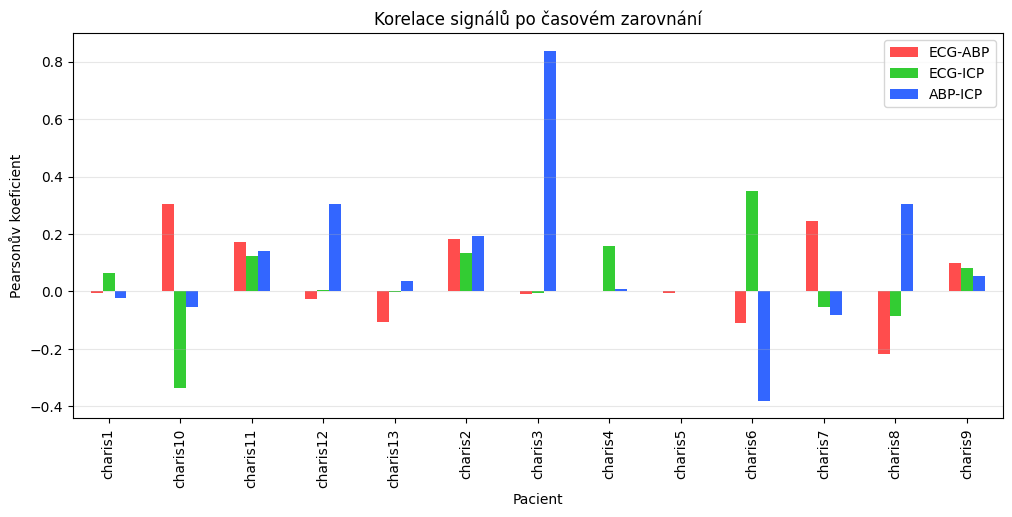


Počítám matici ABP mezi pacienty...


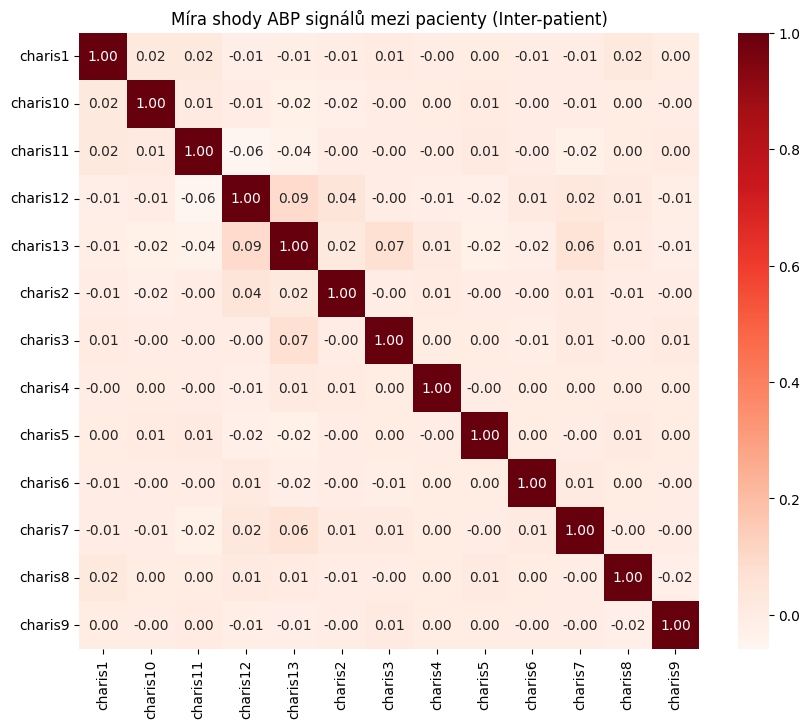

In [14]:
import os
import numpy as np
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import resample, correlate

# --- NASTAVENÍ ---
DATA_PATH = "./data_charis"
TARGET_FS = 100  # Sjednocená frekvence (vystačí a je rychlá)
DURATION = 3600  # 1 hodina v sekundách

def align_and_correlate(sig1, sig2, fs):
    """
    Srovná signály na stejný počátek (dominantní vrchol) a spočítá korelaci.
    """
    # Pro nalezení posunu použijeme prvních 60 sekund (dominantní vrcholy)
    n = min(len(sig1), int(60 * fs))
    # Použijeme absolutní hodnotu pro zvýraznění energie tepů
    xcorr = correlate(np.abs(sig1[:n]), np.abs(sig2[:n]), mode='full')
    lags = np.arange(-n + 1, n)
    lag = lags[np.argmax(xcorr)]
    
    # Posuneme signály podle nalezeného lagu
    if lag > 0:
        s1, s2 = sig1[:-lag], sig2[lag:]
    elif lag < 0:
        s1, s2 = sig1[abs(lag):], sig2[:lag]
    else:
        s1, s2 = sig1, sig2
        
    m = min(len(s1), len(s2))
    if m < 10: return 0.0
    return np.corrcoef(s1[:m], s2[:m])[0, 1]

def load_patient_data(rec_name):
    """ Načte, ořízne, interpoluje, převzorkuje a centralizuje data. """
    try:
        r = wfdb.rdrecord(os.path.join(DATA_PATH, rec_name))
        sigs = {}
        # Najdeme kanály (EKG, ABP, ICP) podle klíčových slov
        for i, name in enumerate(r.sig_name):
            n = name.upper()
            if any(x in n for x in ['ECG', 'EKG', 'II']): sigs['ECG'] = r.p_signal[:, i]
            elif any(x in n for x in ['ABP', 'ART', 'BP']): sigs['ABP'] = r.p_signal[:, i]
            elif 'ICP' in n: sigs['ICP'] = r.p_signal[:, i]
        
        if len(sigs) < 3: return None

        final_data = {}
        for k, s in sigs.items():
            # 1. Oříznutí na 1 hodinu (před resamplem - důležité pro rychlost!)
            s = s[:int(DURATION * r.fs)]
            # 2. Interpolace NaN
            if np.isnan(s).any():
                s = pd.Series(s).interpolate(limit_direction='both').to_numpy()
            # 3. Převzorkování
            if r.fs != TARGET_FS:
                s = resample(s, int(DURATION * TARGET_FS))
            # 4. Centralizace
            final_data[k] = s - np.mean(s)
            
        return final_data
    except: return None

# --- HLAVNÍ VÝPOČET ---

if not os.path.exists(DATA_PATH):
    print(f"Složka {DATA_PATH} nebyla nalezena!")
else:
    records = sorted({f.split('.')[0] for f in os.listdir(DATA_PATH) if f.endswith(".hea")})
    print(f"Zpracovávám {len(records)} pacientů...")

    results = []
    abp_all = []
    labels = []

    for rec in records:
        data = load_patient_data(rec)
        if data:
            # Korelace v rámci pacienta (Intra-patient)
            c_ea = align_and_correlate(data['ECG'], data['ABP'], TARGET_FS)
            c_ei = align_and_correlate(data['ECG'], data['ICP'], TARGET_FS)
            c_ai = align_and_correlate(data['ABP'], data['ICP'], TARGET_FS)
            
            results.append({'Pacient': rec, 'ECG-ABP': c_ea, 'ECG-ICP': c_ei, 'ABP-ICP': c_ai})
            abp_all.append(data['ABP'])
            labels.append(rec)

    # --- TABULKA A GRAFY ---

    df = pd.DataFrame(results)
    print("\nTABULKA KORELACÍ (Intra-patient):")
    print(df.to_string(index=False))

    # Graf 1: Korelace u jednotlivých pacientů
    df.plot(x='Pacient', kind='bar', figsize=(12, 5), color=['#ff4d4d', '#33cc33', '#3366ff'])
    plt.title("Korelace signálů po časovém zarovnání")
    plt.ylabel("Pearsonův koeficient")
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # Graf 2: Matice korelací ABP mezi pacienty (Inter-patient)
    n = len(abp_all)
    matrix = np.zeros((n, n))
    print("\nPočítám matici ABP mezi pacienty...")
    for i in range(n):
        for j in range(i, n):
            c = align_and_correlate(abp_all[i], abp_all[j], TARGET_FS)
            matrix[i, j] = matrix[j, i] = c

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt=".2f", cmap='Reds')
    plt.title("Míra shody ABP signálů mezi pacienty (Inter-patient)")
    plt.show()